In [2]:
from lib_util import utils, audio_functions as af, plot
import soundfile as sf
import pandas as pd
import numpy as np
import os
import librosa
import librosa.feature
from tqdm import tqdm
from random import randint
import yaml
from random import randint


%load_ext autoreload
%autoreload 2
%matplotlib inline

# Preprocessing of the audio files
Perform some steps to preprocess audio files and convert them into a feature vector
## Preprocess converted WAV files
### Read in the audio data from the directory structure
read in the data and store the audio content together with the directory path to save the information of the associatated class label

In [2]:
loaded_audio_files, dirs = zip(*[ (sf.read(audio_file_name, dtype='float32'), os.path.dirname(audio_file_name)) for audio_file_name in utils.audio_file_iterator()])

Processing genre directory '09 Disco Funk'
   Processed 298 files          
Processing genre directory '12 Chinese Traditional'
   Processed 300 files          
Processing genre directory '15 Reggaeton Pop'
   Processed 322 files          
Processing genre directory '06 Deep House'
   Processed 360 files          
Processing genre directory 'Keyboard Collection'
   Processed 164 files          


# Read in config file

In [21]:
config = utils.get_config('preprocess')

## One Hot Encoding
Get the directory names form the data folder, which are used to identify the name of the classes and encode the feature labels using a One-Hot-Encoding.

In [6]:
from sklearn.preprocessing import OneHotEncoder

class_idx = 0
# remove leading directory name
sliced_dir_names = list(map(lambda s: s.replace('wav_data\\', ''), dirs))

ohe = OneHotEncoder()
ohe_labels = ohe.fit_transform(np.array(sliced_dir_names).reshape(-1, 1))

cats = ohe.categories_[0]
print("Categories ({n}):".format(n=len(cats)))
[print("   ", cat) for cat in cats]

ohe_labels_array = ohe_labels.toarray()

Categories (5):
    wav_data/06 Deep House
    wav_data/09 Disco Funk
    wav_data/12 Chinese Traditional
    wav_data/15 Reggaeton Pop
    wav_data/Keyboard Collection


Save the label vector and the class mapping to seperate files

### perform sequential several preprocessing steps
 - slice audio to 3s unit length snippets (zero-padded if shorter)
 - convert track to mono audio
 - downsample audio files to 4kBit

First, all samples are cut into a unit time length and stored in a list of tuples, where each list elements is a tuple, consisting of a 3-second audio snippet and its samplerate

In [7]:
unit_length = config['unit_length_ms']
downsample_rate = config['downsample_rate']

In [8]:
to_multi_slices = lambda t: (af.multi_slice_to_length(t[0], t[1], unit_length), t[1])

unit_length_audio = tqdm(map(to_multi_slices, loaded_audio_files))

unit_length_audio, sr = zip(*unit_length_audio)

appended_slice_lengths = [len(u) for u in unit_length_audio]

unit_length_audio = [item for sublist in unit_length_audio for item in sublist]

print("Number of unit length samples:", len(unit_length_audio))

assert sum(appended_slice_lengths) == len(unit_length_audio)

1444it [00:02, 634.47it/s]

Number of unit length samples: 4068


Append the label vector according to the appended features  
Since some of the features has been duplicated because of the slicing to unit length, so the label vector has to be extended too

In [9]:
ohe_labels_array_extended = ohe_labels_array

offset = 0

for idx, append_size in enumerate(appended_slice_lengths):
    if append_size == 1:
        continue
    to_insert = np.tile(ohe_labels_array[idx, :], (append_size-1, 1))
    ohe_labels_array_extended = np.insert(ohe_labels_array_extended, idx+1+offset, to_insert, axis=0)
    offset += append_size-1

n_samples = ohe_labels_array_extended.shape[0]
print(n_samples)
assert sum(appended_slice_lengths) == ohe_labels_array_extended.shape[0]

4068


Save extended label vector and the category mapping

In [10]:
import json

np.save('data/labels.npy', ohe_labels_array_extended)

cats_dict = {}
for i, c in enumerate(cats):
    cats_dict[c.removeprefix('wav_data/')] = i

with open('data/class_label_index_mapping.json', 'w') as f:
    json.dump(cats_dict, f, indent=4)

{'Keyboard Collection': 621, '15 Reggaeton Pop': 942, '12 Chinese Traditional': 982, '09 Disco Funk': 664, '06 Deep House': 859}


<BarContainer object of 5 artists>

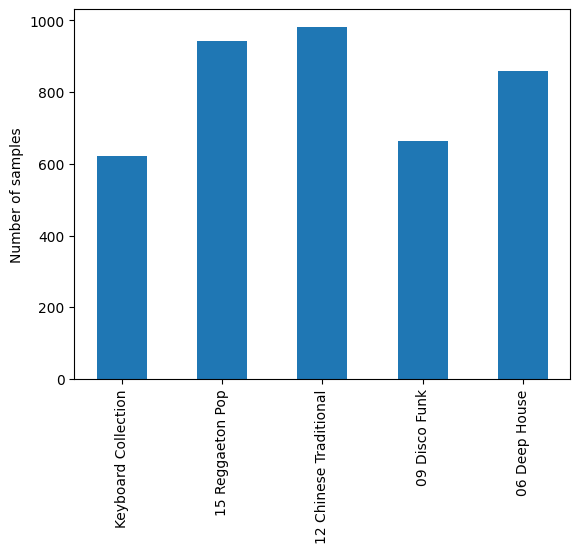

In [18]:
from matplotlib import pyplot as plt

labels = np.load('data/labels.npy')
distr = utils.get_label_distribution(labels)

print(distr)

fig, ax = plt.subplots()
plt.xticks(rotation=90)
plt.ylabel('Number of samples')
ax.bar(range(5), [distr[key] for key in distr], tick_label=[key for key in distr], width=0.5)

define and prepare preprocessing steps with the corresponding parameters:

In [11]:
to_mono = lambda t : (af.to_mono_channel(t[0]), t[1])
resample = lambda t : (af.resample(t[0], t[1], downsample_rate), t[1])

preprocessing_steps = [
    to_mono,
    resample
]

features_preprocessed = unit_length_audio
for step in preprocessing_steps:
    features_preprocessed = map(step, features_preprocessed)

perform preprocessing from generator-pipline and extract the features as an numpy-array

In [12]:
features, _ = zip(*tqdm(features_preprocessed, total=n_samples))
feature_array = np.vstack(features)

4068it [10:21,  6.55it/s]


### Store the data
Save the data in numpy format  
Summary:
- samples of 3 seconds length
- sample rate of 4kHz
- mono audio
- samples whose length was above 3 seconds were sliced into multiple snippets, with the last snippet being zero-padded in the end 

In [13]:
print("Feature array uses {s:.2f} MB of disc space".format(s=feature_array.nbytes/1024/1024))

utils.save_numpy_array_sliced('preprocessed_data', feature_array)

Feature array uses 744.87 MB of disc space
Saved file to slices preprocessed_data
   saved slice 001 to  preprocessed_data_001
   saved slice 002 to  preprocessed_data_002
   saved slice 003 to  preprocessed_data_003
   saved slice 004 to  preprocessed_data_004
   saved slice 005 to  preprocessed_data_005
   saved slice 006 to  preprocessed_data_006
   saved slice 007 to  preprocessed_data_007
   saved slice 008 to  preprocessed_data_008
   saved slice 009 to  preprocessed_data_009


9

### Validation  
Load the file with the stored feature arrays

In [14]:
feature_array = utils.load_sliced_numpy_array('preprocessed_data')

print(feature_array.shape)

Load slice from file preprocessed_data_001.npy
Load slice from file preprocessed_data_002.npy
Load slice from file preprocessed_data_003.npy
Load slice from file preprocessed_data_004.npy
Load slice from file preprocessed_data_005.npy
Load slice from file preprocessed_data_006.npy
Load slice from file preprocessed_data_007.npy
Load slice from file preprocessed_data_008.npy
Load slice from file preprocessed_data_009.npy
Loaded 9 files as slices, resulting shape: (4068, 48000)
(4068, 48000)


Plot a random example of a waveform from the preprocessed data to verify the preprocessing steps  
The saved data are laoded before

Plot audio sample 1151
Dimensions: (48000,)


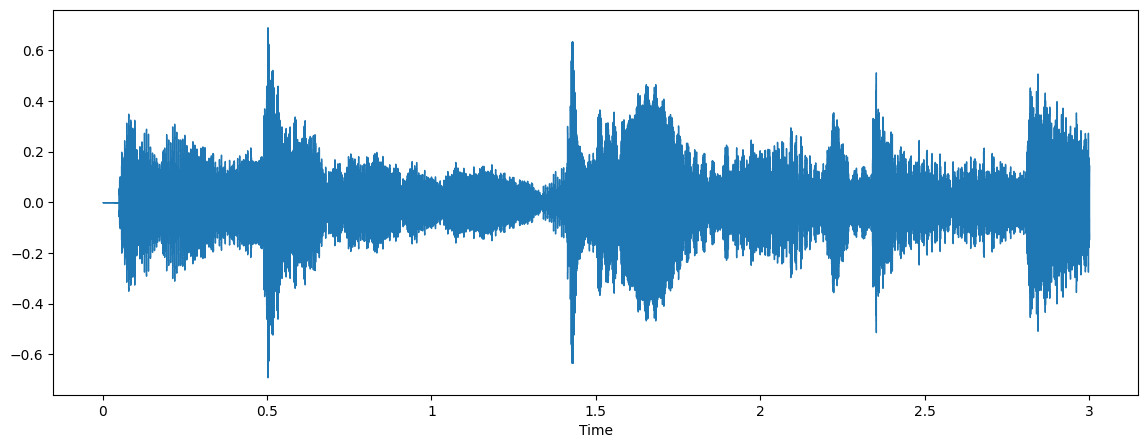

In [15]:
x = randint(0, len(feature_array)-1)
random_feature = feature_array[x, :]

print("Plot audio sample", x)
plot.plot_waveform(random_feature, downsample_rate)

print("Dimensions:", random_feature.shape)

# Check for correct sample rate, length and for mono-track
assert random_feature.shape[0] == unit_length*downsample_rate/1000 and len(random_feature.shape) == 1

## Compute the melspectogram from the features

In [14]:
to_mono = lambda t : (af.to_mono_channel(t[0]), t[1])

print("Convert to mono lenght")
mono_unit_length_audio, s_rates = zip(*tqdm(map(to_mono, unit_length_audio)))
print("Stack to a single matrix")
mono_unit_length_audio_array = np.vstack(mono_unit_length_audio)

print(mono_unit_length_audio_array.shape)

Convert to mono lenght


4068it [00:10, 375.05it/s]


Stack to a single matrix
(4068, 132300)


In [15]:
sample_rate = s_rates[0]
n_mels = config['melspectogram']['n_mels']
f_max = sample_rate/2
hop_length = config['melspectogram']['hop_length']

get_melspectogram = lambda t: librosa.power_to_db(librosa.feature.melspectrogram(y=t, sr=sample_rate, n_mels=n_mels, fmax=f_max, hop_length=hop_length)).flatten()

print("Compute the melspectogram")
features_spectogram = list(tqdm(map(get_melspectogram, mono_unit_length_audio_array)))

print("Stack to a single matrix")
features_spectogram = np.vstack(features_spectogram)

print("Shape of the feature vector:", features_spectogram.shape)

Compute the melspectogram


4068it [00:44, 90.97it/s] 


Stack to a single matrix
Shape of the feature vector: (4068, 33152)


### Save the melspectogram arrays

In [22]:
print("Feature array uses {s:.2f} MB of disc space".format(s=features_spectogram.nbytes/1024/1024))

utils.save_numpy_array_sliced('melspec_features', features_spectogram, max_size_mb=45)

Feature array uses 514.46 MB of disc space
Saved file to slices melspec_features
   saved slice 001 to  melspec_features_001
   saved slice 002 to  melspec_features_002
   saved slice 003 to  melspec_features_003
   saved slice 004 to  melspec_features_004
   saved slice 005 to  melspec_features_005
   saved slice 006 to  melspec_features_006
   saved slice 007 to  melspec_features_007
   saved slice 008 to  melspec_features_008
   saved slice 009 to  melspec_features_009
   saved slice 010 to  melspec_features_010
   saved slice 011 to  melspec_features_011
   saved slice 012 to  melspec_features_012


### Load and validate
Load the melspectogram features and plot an example

Load slice from file melspec_features_001.npy
Load slice from file melspec_features_002.npy
Load slice from file melspec_features_003.npy
Load slice from file melspec_features_004.npy
Load slice from file melspec_features_005.npy
Load slice from file melspec_features_006.npy
Load slice from file melspec_features_007.npy
Load slice from file melspec_features_008.npy
Load slice from file melspec_features_009.npy
Load slice from file melspec_features_010.npy
Load slice from file melspec_features_011.npy
Load slice from file melspec_features_012.npy
Loaded 12 files as slices, resulting shape: (4068, 33152)
Plot melspec for feature 814 (12 Chinese Traditional):



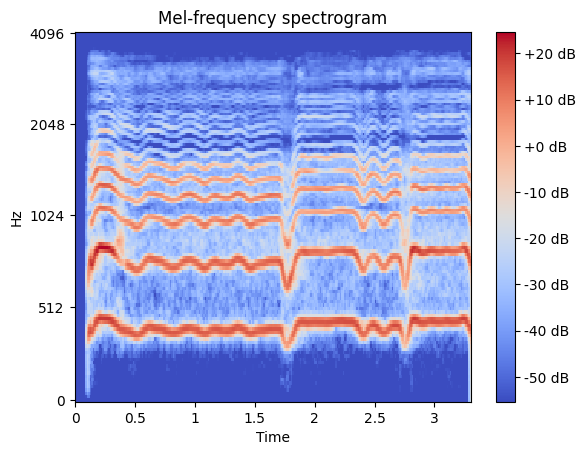

In [29]:
features_spectogram = utils.load_sliced_numpy_array('melspec_features')
labels = np.load('data/labels.npy')

n_mels = config['melspectogram']['n_mels']

x = randint(0, features_spectogram.shape[0]-1)

labels_to_id = utils.get_class_mapping()
id_to_labels = {}
for key in labels_to_id:
    id_to_labels[labels_to_id[key]] = key

print(f'Plot melspec for feature {x} ({id_to_labels[np.argmax(labels[x])]}):')

feature_to_plot = features_spectogram[x, :].reshape(n_mels, -1)
print()
plot.plot_melspectogram(feature_to_plot, 40_000, fmax=4096, calculate_db=False, save_fig=False)

Test data distribution

In [16]:
from sklearn.model_selection import train_test_split

melspec_data = utils.load_sliced_numpy_array('melspec_features')
labels = np.load('data/labels.npy')

labels_to_id = utils.get_class_mapping()

train_size = 0.7
validation_size = 0.15

mel_train, mel_test_val, lab_train, lab_test_val = train_test_split(melspec_data, labels, train_size=train_size, random_state=420)
mel_val, mel_test, lab_val, lab_test             = train_test_split(mel_test_val, lab_test_val, test_size=(validation_size/(1-train_size)), shuffle=False)

# Check the shapes of the splitted sets
assert mel_train.shape[0] == lab_train.shape[0] and mel_test.shape[0] == lab_test.shape[0] and mel_val.shape[0] == lab_val.shape[0]
assert mel_train.shape[1] == mel_test.shape[1] == mel_val.shape[1] and lab_train.shape[1] == lab_test.shape[1] == lab_val.shape[1]


Load slice from file melspec_features_001.npy
Load slice from file melspec_features_002.npy
Load slice from file melspec_features_003.npy
Load slice from file melspec_features_004.npy
Load slice from file melspec_features_005.npy
Load slice from file melspec_features_006.npy
Load slice from file melspec_features_007.npy
Load slice from file melspec_features_008.npy
Load slice from file melspec_features_009.npy
Load slice from file melspec_features_010.npy
Load slice from file melspec_features_011.npy
Load slice from file melspec_features_012.npy
Loaded 12 files as slices, resulting shape: (4068, 33152)
Distribution of labels in train set: (array([0., 1.]), array([11388,  2847]))
Distribution of labels in validation set: (array([0., 1.]), array([2440,  610]))


In [31]:
from lib_util import utils

train_labels, train_distr = np.unique(np.argmax(lab_train, axis=1), return_counts=True, axis=0)
val_labels, val_distr = np.unique(np.argmax(lab_val, axis=1), return_counts=True, axis=0)

train_distr = np.round(train_distr/np.sum(train_distr), 2)
val_distr = np.round(val_distr/np.sum(val_distr), 2)

labels_to_id = utils.get_class_mapping()
id_to_labels = {}
for key in labels_to_id:
    id_to_labels[labels_to_id[key]] = key

train_id_distr = dict(zip(train_labels, train_distr))
val_id_distr = dict(zip(val_labels, val_distr))

train_labels_distr = {}
val_labels_distr = {}

for key in train_id_distr:
    train_labels_distr[id_to_labels[key]] = train_id_distr[key]
for key in val_id_distr:
    val_labels_distr[id_to_labels[key]] = val_id_distr[key]

print("Distribution of labels in train set:     ", train_labels_distr)
print("Distribution of labels in validation set:", val_labels_distr)

Distribution of labels in train set:      {'06 Deep House': 0.21, '09 Disco Funk': 0.16, '12 Chinese Traditional': 0.24, '15 Reggaeton Pop': 0.23, 'Keyboard Collection': 0.15}
Distribution of labels in validation set: {'06 Deep House': 0.21, '09 Disco Funk': 0.18, '12 Chinese Traditional': 0.22, '15 Reggaeton Pop': 0.24, 'Keyboard Collection': 0.15}
